In [1]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [5]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [6]:
train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

In [7]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples[:, ::-1, :], targets

In [8]:
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback, 
    delay=delay, 
    min_index=0, 
    max_index=200000, 
    shuffle=True, 
    step=step, 
    batch_size=batch_size
)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback, 
    delay=delay, 
    min_index=200001, 
    max_index=300000, 
    shuffle=True, 
    step=step, 
    batch_size=batch_size
)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen_reverse, 
                    steps_per_epoch=500, 
                    epochs=20, 
                    validation_data=val_gen_reverse, 
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 97ms/step - loss: 0.4896 - val_loss: 0.4833
Epoch 2/20
500/500 [==============================] - 47s 95ms/step - loss: 0.4384 - val_loss: 0.4712
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3849 - val_loss: 0.4043
Epoch 4/20
500/500 [==============================] - 48s 95ms/step - loss: 0.3514 - val_loss: 0.3502
Epoch 5/20
500/500 [==============================] - 47s 95ms/step - loss: 0.3163 - val_loss: 0.3301
Epoch 6/20
500/500 [==============================] - 46s 93ms/step - loss: 0.2931 - val_loss: 0.3215
Epoch 7/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2785 - val_loss: 0.3147
Epoch 8/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2713 - val_loss: 0.3322
Epoch 9/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2636 - val_loss: 0.3130
Epoch 10/20
500/500 [==============================] - 46s 92ms/step - loss: 0.255

In [10]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

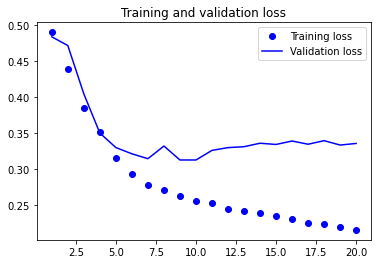

In [11]:
plot_loss(history)

In [12]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [13]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 38s 232ms/step - loss: 0.4784 - acc: 0.7759 - val_loss: 0.3716 - val_acc: 0.8612
Epoch 2/10
157/157 [==============================] - 36s 231ms/step - loss: 0.3072 - acc: 0.8814 - val_loss: 0.4096 - val_acc: 0.8468
Epoch 3/10
157/157 [==============================] - 36s 231ms/step - loss: 0.2598 - acc: 0.9044 - val_loss: 0.3781 - val_acc: 0.8444
Epoch 4/10
157/157 [==============================] - 36s 232ms/step - loss: 0.2183 - acc: 0.9207 - val_loss: 0.3347 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 36s 232ms/step - loss: 0.2192 - acc: 0.9267 - val_loss: 0.3791 - val_acc: 0.8768
Epoch 6/10
157/157 [==============================] - 36s 231ms/step - loss: 0.1858 - acc: 0.9370 - val_loss: 0.3403 - val_acc: 0.8708
Epoch 7/10
157/157 [==============================] - 36s 228ms/step - loss: 0.1652 - acc: 0.9441 - val_loss: 0.4130 - val_acc: 0.8546
Epoch 8/10
157/157 [==============================] - 3

In [14]:
from tensorflow.keras import backend as K

K.clear_session()

In [15]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 54s 335ms/step - loss: 0.5351 - acc: 0.7367 - val_loss: 1.1166 - val_acc: 0.5864
Epoch 2/10
157/157 [==============================] - 51s 325ms/step - loss: 0.3246 - acc: 0.8740 - val_loss: 0.5847 - val_acc: 0.7826
Epoch 3/10
157/157 [==============================] - 51s 326ms/step - loss: 0.2619 - acc: 0.9036 - val_loss: 0.3358 - val_acc: 0.8712
Epoch 4/10
157/157 [==============================] - 51s 324ms/step - loss: 0.2216 - acc: 0.9190 - val_loss: 0.2979 - val_acc: 0.8892
Epoch 5/10
157/157 [==============================] - 51s 325ms/step - loss: 0.2025 - acc: 0.9277 - val_loss: 0.3394 - val_acc: 0.8906
Epoch 6/10
157/157 [==============================] - 51s 327ms/step - loss: 0.1775 - acc: 0.9374 - val_loss: 0.3569 - val_acc: 0.8822
Epoch 7/10
157/157 [==============================] - 52s 334ms/step - loss: 0.1671 - acc: 0.9416 - val_loss: 0.4113 - val_acc: 0.8532
Epoch 8/10
157/157 [==============================] - 5

In [16]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, 
                    steps_per_epoch=500, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 70s 136ms/step - loss: 0.2900 - val_loss: 0.2717
Epoch 2/40
500/500 [==============================] - 67s 135ms/step - loss: 0.2729 - val_loss: 0.2891
Epoch 3/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2665 - val_loss: 0.2652
Epoch 4/40
500/500 [==============================] - 67s 134ms/step - loss: 0.2591 - val_loss: 0.2689
Epoch 5/40
500/500 [==============================] - 66s 132ms/step - loss: 0.2541 - val_loss: 0.2716
Epoch 6/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2494 - val_loss: 0.2804
Epoch 7/40
500/500 [==============================] - 67s 133ms/step - loss: 0.2413 - val_loss: 0.2770
Epoch 8/40
500/500 [==============================] - 69s 139ms/step - loss: 0.2365 - val_loss: 0.2761
Epoch 9/40
500/500 [==============================] - 67s 134ms/step - loss: 0.2302 - val_loss: 0.2803
Epoch 10/40
500/500 [==============================] - 68s 136ms/step - l